#### Libraries

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import string

# Exploratory Data Analysis

### Visualización y análisis de datos

In [8]:
sns.set(style = 'whitegrid')
plt.rcParams["figure.figsize"] = (12, 6)

data = pd.read_json("data.json")
data.dropna(subset=['headline', 'category'], inplace=True)

In [9]:
# Análisis de datos (formato)
print(data.shape)
data.head()

(209527, 2)


,headline,category
0,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS
1,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS
2,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY
3,The Funniest Tweets From Parents This Week (Se...,PARENTING
4,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 209527 entries, 0 to 209526
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   headline  209527 non-null  object
 1   category  209527 non-null  object
dtypes: object(2)
memory usage: 4.8+ MB


In [11]:
# Categorias tienen inconsistencias

print("Cantidad de registros:", len(data))
print("Número de categorías únicas:", data['category'].nunique())
print(data['category'].unique())

Cantidad de registros: 209527
Número de categorías únicas: 42
['U.S. NEWS' 'COMEDY' 'PARENTING' 'WORLD NEWS' 'CULTURE & ARTS' 'TECH'
 'SPORTS' 'ENTERTAINMENT' 'POLITICS' 'WEIRD NEWS' 'ENVIRONMENT'
 'EDUCATION' 'CRIME' 'SCIENCE' 'WELLNESS' 'BUSINESS' 'STYLE & BEAUTY'
 'FOOD & DRINK' 'MEDIA' 'QUEER VOICES' 'HOME & LIVING' 'WOMEN'
 'BLACK VOICES' 'TRAVEL' 'MONEY' 'RELIGION' 'LATINO VOICES' 'IMPACT'
 'WEDDINGS' 'COLLEGE' 'PARENTS' 'ARTS & CULTURE' 'STYLE' 'GREEN' 'TASTE'
 'HEALTHY LIVING' 'THE WORLDPOST' 'GOOD NEWS' 'WORLDPOST' 'FIFTY' 'ARTS'
 'DIVORCE']


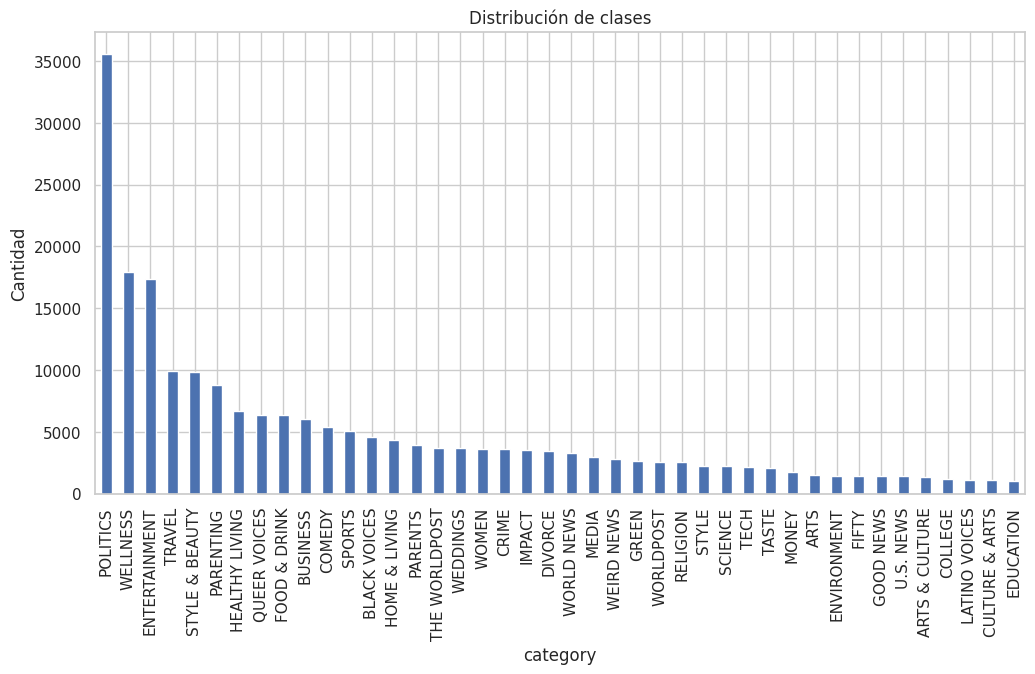

In [12]:
# Conjunto de datos desbalanceado

data['category'].value_counts().plot(kind='bar', title='Distribución de clases', ylabel='Cantidad')
plt.xticks(rotation=90)
plt.show()

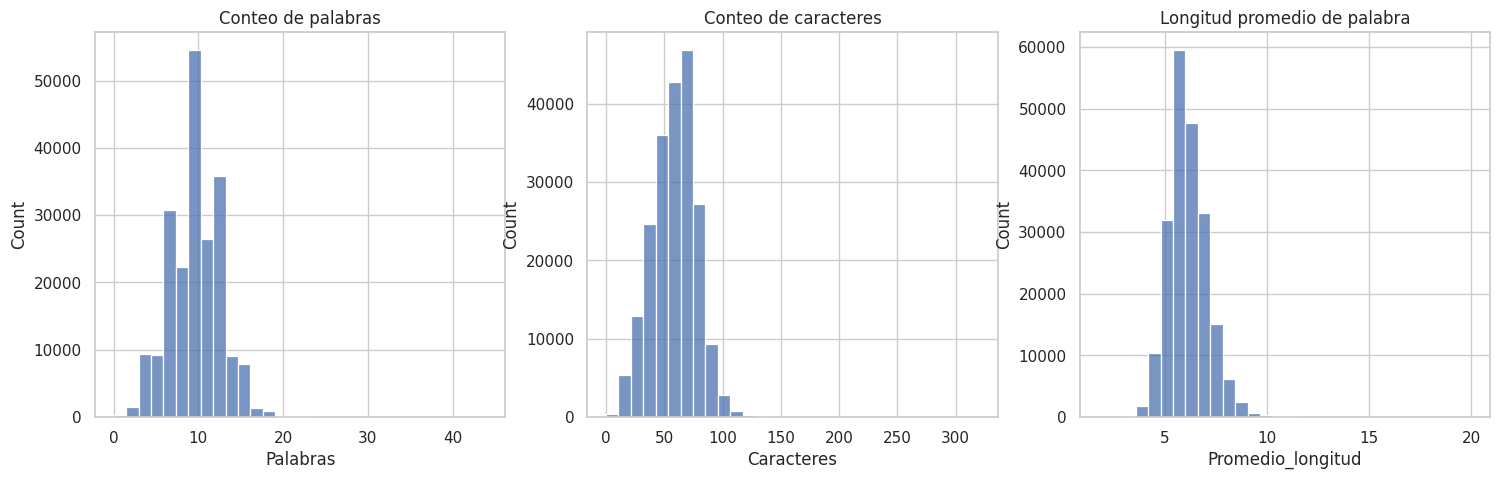

In [13]:
# La cantidad de palabras de headlines sigue una distribución normal

data_plot = data.copy()
data_plot['Palabras'] = data_plot['headline'].apply(lambda x: len(str(x).split()))
data_plot['Caracteres'] = data_plot['headline'].apply(lambda x: len(str(x)))
data_plot['Promedio_longitud'] = data_plot['Caracteres'] / data_plot['Palabras']

# Histogramas
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
sns.histplot(data_plot['Palabras'], bins=30, ax=axs[0])
axs[0].set_title('Conteo de palabras')
sns.histplot(data_plot['Caracteres'], bins=30, ax=axs[1])
axs[1].set_title('Conteo de caracteres')
sns.histplot(data_plot['Promedio_longitud'], bins=30, ax=axs[2])
axs[2].set_title('Longitud promedio de palabra')
plt.show()

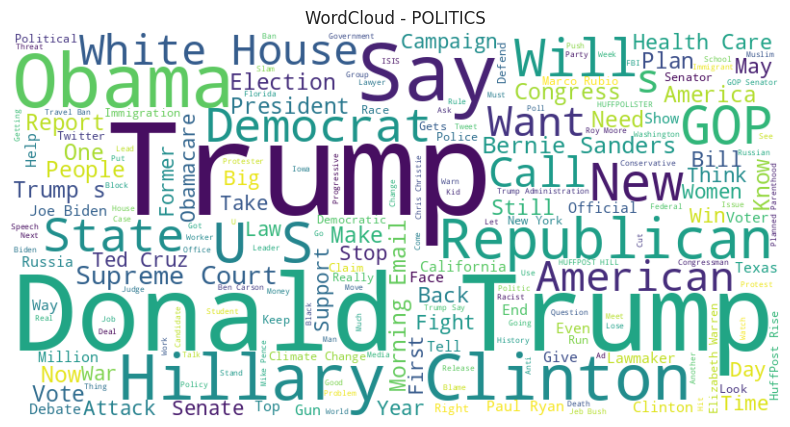

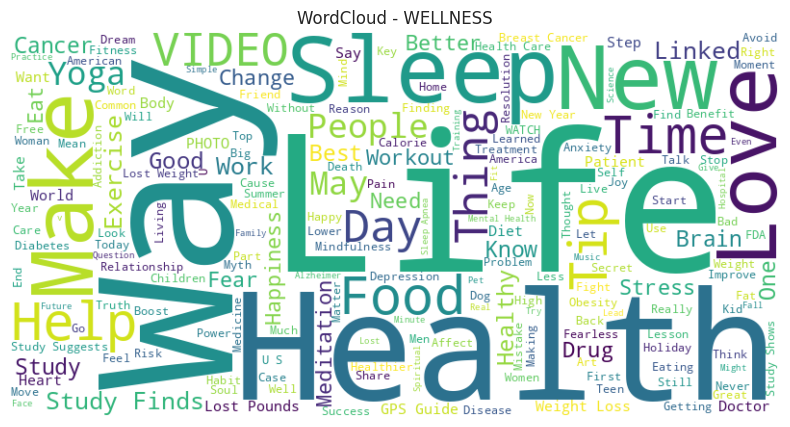

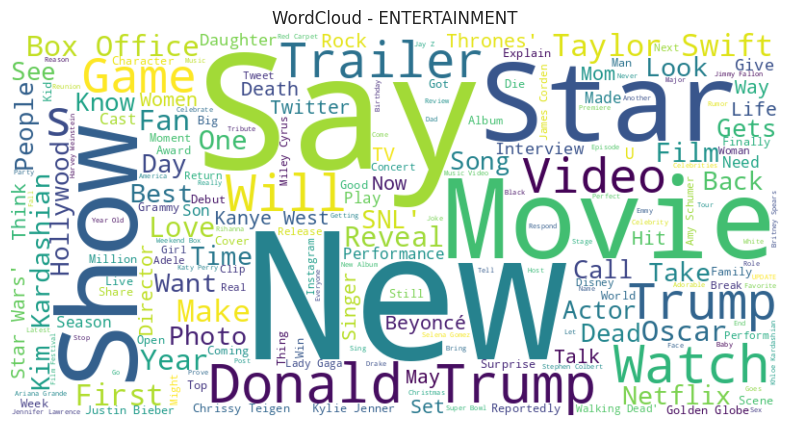

In [14]:
# Visualización de palabras relevantes por categoría

def plot_wordcloud(category_name, data):
    text = " ".join(data[data['category'] == category_name]['headline'].astype(str))
    wc = WordCloud(width=800, height=400, background_color='white', max_words=200).generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"WordCloud - {category_name}")
    plt.show()


for cat in data['category'].value_counts().head(3).index:
    plot_wordcloud(cat, data)

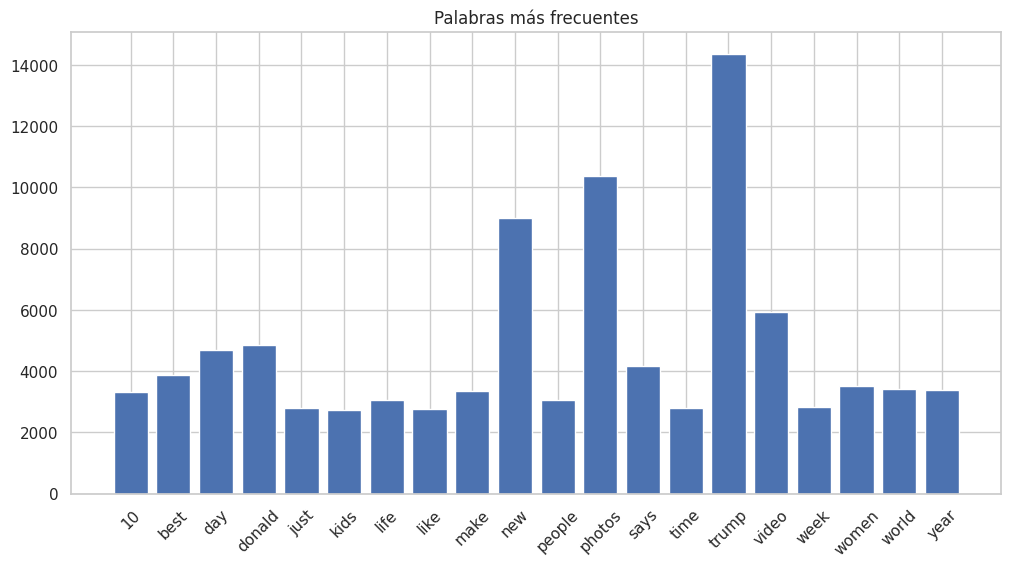

In [15]:
# Obtener palabras más usadas en todo el conjunto de datos
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(stop_words = 'english', max_features = 20)
X = vectorizer.fit_transform(data['headline'].astype(str))
word_freq = dict(zip(vectorizer.get_feature_names_out(), np.asarray(X.sum(axis = 0)).ravel()))

plt.bar(word_freq.keys(), word_freq.values())
plt.xticks(rotation=45)
plt.title("Palabras más frecuentes")
plt.show()

                 Palabras  Caracteres
category                             
GOOD NEWS       10.823319   64.000000
ENTERTAINMENT   10.672503   64.620781
U.S. NEWS       10.672476   68.381990
ARTS & CULTURE  10.590739   65.214339
LATINO VOICES   10.512389   65.011504


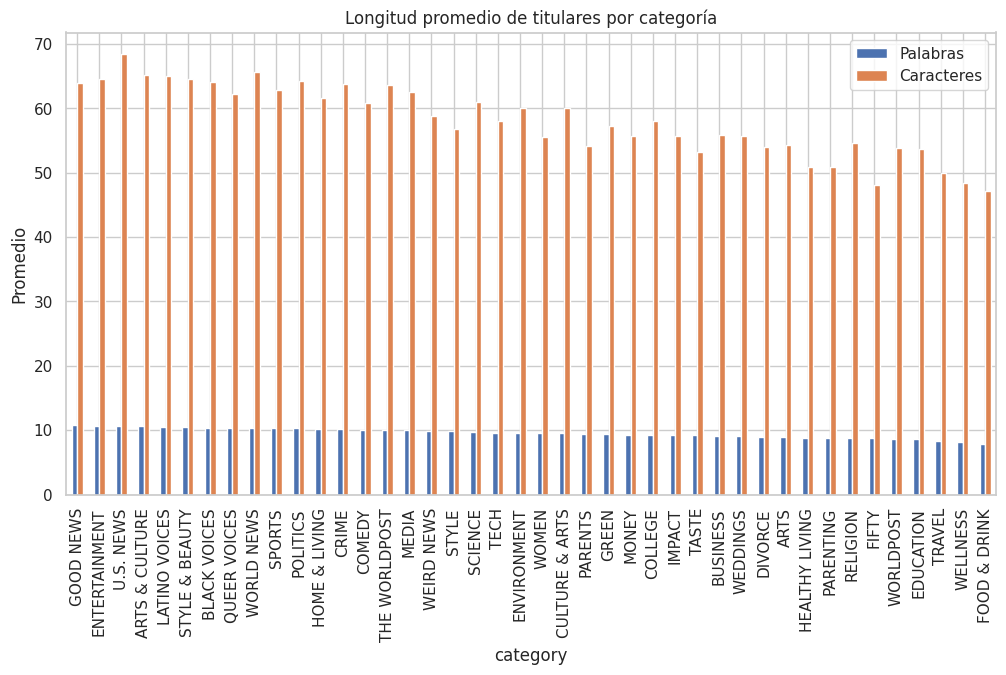

In [16]:
length_stats = data_plot.groupby('category')[['Palabras', 'Caracteres']].mean().sort_values('Palabras', ascending=False)
print(length_stats.head())

length_stats.plot(kind='bar')
plt.title('Longitud promedio de titulares por categoría')
plt.ylabel('Promedio')
plt.xticks(rotation=90)
plt.show()

### Limpieza de datos

In [17]:
data.isnull().sum()

,0
headline,0
category,0


In [18]:
empty_headlines = data[data['headline'].str.strip() == '']
empty_headlines

,headline,category
90944,,POLITICS
95567,,RELIGION
103675,,WORLDPOST
109100,,BUSINESS
110153,,MEDIA
122145,,QUEER VOICES


In [19]:
duplicate_headlines = data['headline'].value_counts()
duplicate_headlines = duplicate_headlines[duplicate_headlines > 1]

duplicate_headlines

,count
headline,
Sunday Roundup,90
The 20 Funniest Tweets From Women This Week,80
Weekly Roundup of eBay Vintage Clothing Finds (PHOTOS),59
Weekly Roundup of eBay Vintage Home Finds (PHOTOS),54
Watch The Top 9 YouTube Videos Of The Week,46
...,...
"Trump Campaign Manager Faces New Allegations Of Pushing, Sexually Suggestive Comments",2
Is Fashion Gaming The Next Marketing Frontier?,2
"Hilary Duff Dons Leather Leggings, Tube Top For Night Out (PHOTOS)",2


In [20]:
data = data.drop_duplicates(subset = "headline")
data = data[data['headline'].str.strip() != '']
data.to_json("data_cleaned.json")

print(data.shape)

(207995, 2)


# Feature Engineering

In [21]:
import string
import re

import pandas as pd

from scipy.sparse import hstack, csr_matrix

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

In [22]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Reemplazar categorias por grupos (Reduccion de ruido - Reducir el imbalance)
category_group_map = {

    # Política
    'POLITICS': 'POLITICS',

    # Noticias
    'U.S. NEWS': 'NEWS',
    'WORLD NEWS': 'NEWS',
    'THE WORLDPOST': 'NEWS',
    'WORLDPOST': 'NEWS',

    # Sociedad, crimen, eventos, impacto
    'CRIME': 'SOCIETY & EVENTS',
    'WEIRD NEWS': 'SOCIETY & EVENTS',
    'GOOD NEWS': 'SOCIETY & EVENTS',
    'IMPACT': 'SOCIETY & EVENTS',
    'SOCIAL IMPACT': 'SOCIETY & EVENTS',

    # Entretenimiento y medios
    'ENTERTAINMENT': 'ENTERTAINMENT & MEDIA',
    'COMEDY': 'ENTERTAINMENT & MEDIA',
    'MEDIA': 'ENTERTAINMENT & MEDIA',

    # Ciencia, tecnología, educación
    'SCIENCE': 'SCIENCE & TECH',
    'TECH': 'SCIENCE & TECH',
    'EDUCATION': 'SCIENCE & TECH',
    'COLLEGE': 'SCIENCE & TECH',

    # Cultura, arte y estilo
    'CULTURE & ARTS': 'ART & STYLE',
    'ARTS & CULTURE': 'ART & STYLE',
    'ARTS': 'ART & STYLE',
    'STYLE & BEAUTY': 'ART & STYLE',
    'STYLE': 'ART & STYLE',

    # Bienestar y salud
    'WELLNESS': 'HEALTH & WELLNESS',
    'HEALTHY LIVING': 'HEALTH & WELLNESS',

    # Comida
    'FOOD & DRINK': 'FOOD',
    'TASTE': 'FOOD',

    # Diversidad y voces
    'WOMEN': 'DIVERSITY',
    'BLACK VOICES': 'DIVERSITY',
    'QUEER VOICES': 'DIVERSITY',
    'LATINO VOICES': 'DIVERSITY',

    # Vida y familia
    'HOME & LIVING': 'LIFESTYLE',
    'PARENTING': 'LIFESTYLE',
    'PARENTS': 'LIFESTYLE',
    'TRAVEL': 'LIFESTYLE',
    'RELIGION': 'LIFESTYLE',
    'WEDDINGS': 'LIFESTYLE',
    'DIVORCE': 'LIFESTYLE',
    'FIFTY': 'LIFESTYLE',

    # Negocios y economía
    'BUSINESS': 'BUSINESS',
    'MONEY': 'BUSINESS',

    # Medio ambiente
    'GREEN': 'ENVIRONMENT',
    'ENVIRONMENT': 'ENVIRONMENT',
}

# Aplicar mapeo
def preprocess_text(text):

    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)

    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return ' '.join(tokens)

data = pd.read_json("data_cleaned.json")

data['category'] = data['category'].replace(category_group_map)
data['clean_headline'] = data['headline'].apply(preprocess_text)

data[data['clean_headline'] == '']

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


,headline,category,clean_headline
111413,1998,LIFESTYLE,
113992,Ένας νεκρός σε συγκρούσεις μεταξύ διαδηλωτών κ...,ENVIRONMENT,
121268,8:00,HEALTH & WELLNESS,
125181,50/50,SOCIETY & EVENTS,
181215,15,LIFESTYLE,


In [23]:
data = data[data['clean_headline'] != '']
data.head()

,headline,category,clean_headline
0,Over 4 Million Americans Roll Up Sleeves For O...,NEWS,over million american roll up sleeve for omicr...
1,"American Airlines Flyer Charged, Banned For Li...",NEWS,american airline flyer charged banned for life...
2,23 Of The Funniest Tweets About Cats And Dogs ...,ENTERTAINMENT & MEDIA,of the funniest tweet about cat and dog this w...
3,The Funniest Tweets From Parents This Week (Se...,LIFESTYLE,the funniest tweet from parent this week sept
4,Woman Who Called Cops On Black Bird-Watcher Lo...,NEWS,woman who called cop on black birdwatcher lose...


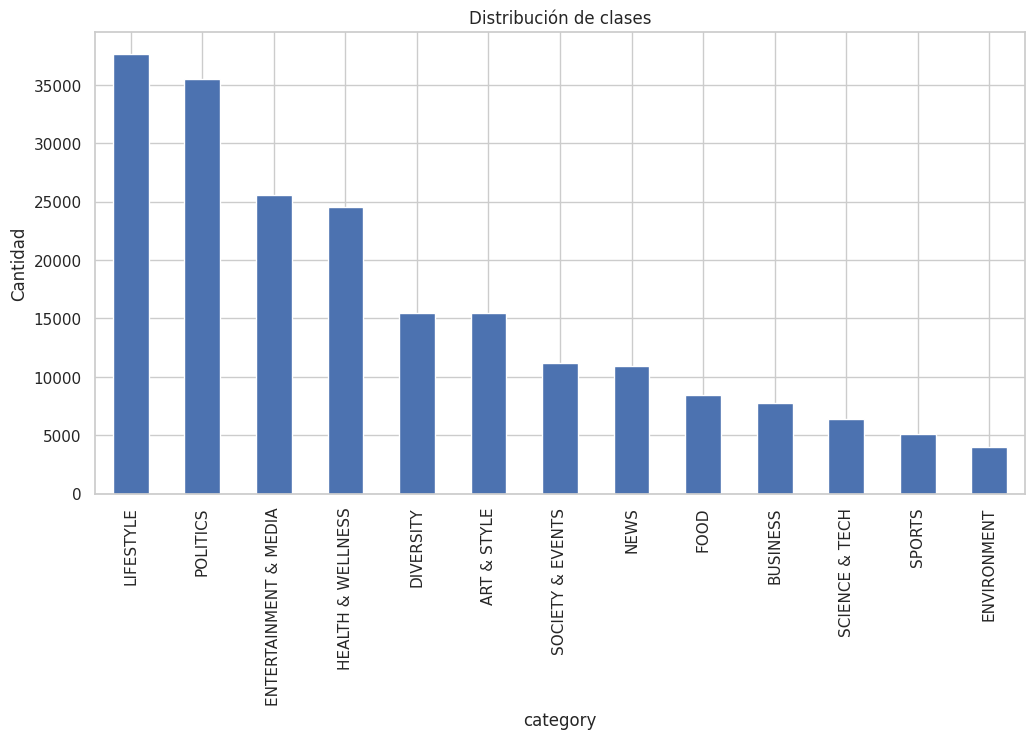

In [24]:
# Nueva distribución
data['category'].value_counts().plot(kind='bar', title='Distribución de clases', ylabel='Cantidad')
plt.xticks(rotation=90)
plt.show()

In [25]:
# Añadiendo nuevas características (Posibilidad de mejorar clasificación)

data['word_count'] = data['headline'].apply(lambda x: len(str(x).split()))
data['char_count'] = data['headline'].apply(lambda x: len(str(x)))
data['avg_word_len'] = data['char_count'] / data['word_count']
data['punctuation_count'] = data['headline'].apply(lambda x: sum(1 for c in str(x) if c in string.punctuation))
data['upper_case_count'] = data['headline'].apply(lambda x: sum(1 for c in str(x) if c.isupper()))
data['upper_case_ratio'] = data['upper_case_count'] / data['char_count']
data['starts_with_number'] = data['headline'].apply(lambda x: str(x)[0].isdigit()).astype(int)
data['contains_number'] = data['headline'].apply(lambda x: any(c.isdigit() for c in str(x))).astype(int)


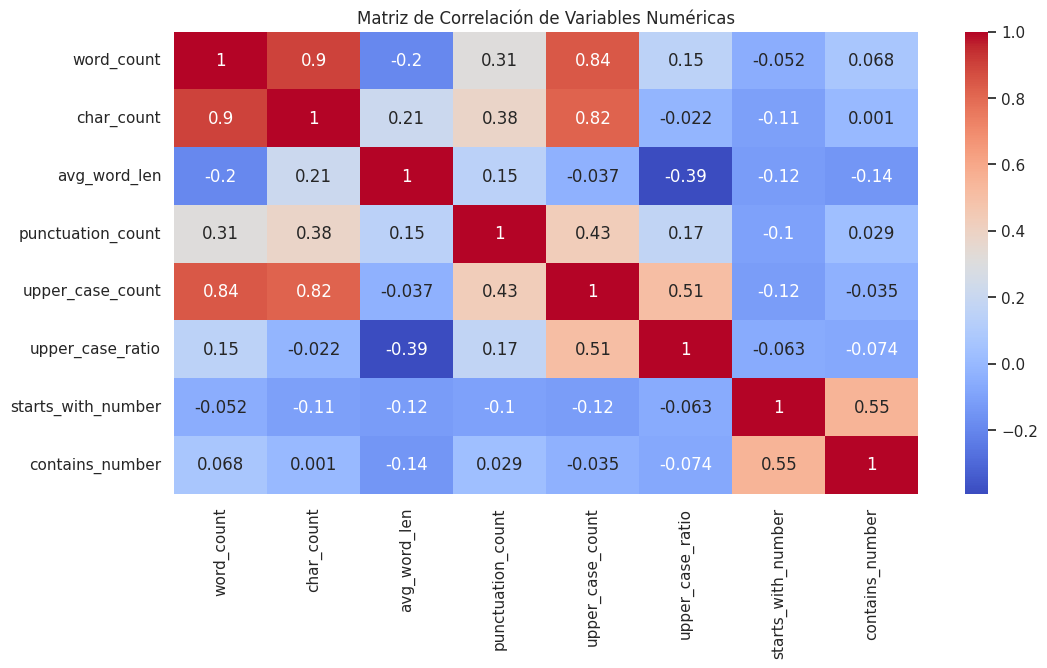

In [26]:
# Eliminar características correlacionadas (No agregan información relevante)
def get_features_num(data):
  features_num = [col for col in data.select_dtypes(include=['int64', 'float64']).columns]

  if 'category' in features_num:
    features_num.remove('category')

  return features_num

features_num = get_features_num(data)

sns.heatmap(data[features_num].corr(), annot=True, cmap='coolwarm')
plt.title("Matriz de Correlación de Variables Numéricas")
plt.show()

In [27]:
# Eliminar características por umbral
threshold = 0.8
features_num = get_features_num(data)
correlation_matrix = data[features_num].corr().abs()

# Obtenemos triangulo superior para comparar valores
upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k = 1).astype(bool))
columns_to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > threshold)]

data_reduced = data.drop(columns=columns_to_drop)
data_reduced.info()

<class 'pandas.core.frame.DataFrame'>
Index: 207990 entries, 0 to 209526
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   headline            207990 non-null  object 
 1   category            207990 non-null  object 
 2   clean_headline      207990 non-null  object 
 3   word_count          207990 non-null  int64  
 4   avg_word_len        207990 non-null  float64
 5   punctuation_count   207990 non-null  int64  
 6   upper_case_ratio    207990 non-null  float64
 7   starts_with_number  207990 non-null  int64  
 8   contains_number     207990 non-null  int64  
dtypes: float64(2), int64(4), object(3)
memory usage: 15.9+ MB


In [28]:
data_reduced.head()

,headline,category,clean_headline,word_count,avg_word_len,punctuation_count,upper_case_ratio,starts_with_number,contains_number
0,Over 4 Million Americans Roll Up Sleeves For O...,NEWS,over million american roll up sleeve for omicr...,11,6.909091,1,0.197368,0,1
1,"American Airlines Flyer Charged, Banned For Li...",NEWS,american airline flyer charged banned for life...,13,6.846154,1,0.146067,0,0
2,23 Of The Funniest Tweets About Cats And Dogs ...,ENTERTAINMENT & MEDIA,of the funniest tweet about cat and dog this w...,13,5.307692,4,0.159420,1,1
3,The Funniest Tweets From Parents This Week (Se...,LIFESTYLE,the funniest tweet from parent this week sept,9,6.222222,4,0.142857,0,1
4,Woman Who Called Cops On Black Bird-Watcher Lo...,NEWS,woman who called cop on black birdwatcher lose...,11,7.000000,2,0.168831,0,0


In [29]:
data_reduced.to_csv('data_encoded.csv', index = False)

# Model Selection

In [6]:
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, accuracy_score

from scipy.sparse import hstack, csr_matrix

from imblearn.over_sampling import RandomOverSampler

# Cargar datos
data = pd.read_csv("data_encoded.csv")

# Normalizar categorías
data['category'] = data['category'].str.upper()

# Reducir categorías con más de 10,000 ejemplos
data_reducida = pd.concat([
    df if len(df) <= 10_000 else df.sample(n=10_000, random_state=42)
    for _, df in data.groupby('category')
]).reset_index(drop=True)

# Codificar etiquetas
le = LabelEncoder()
data_reducida['label_encoded'] = le.fit_transform(data_reducida['category'])
y = data_reducida['label_encoded'].values

# Vectorización TF-IDF
vectorizer = TfidfVectorizer(max_features=3000)
X_text = vectorizer.fit_transform(data_reducida['clean_headline'].fillna(""))

# Features numéricas
num_features = [
    'word_count', 'avg_word_len', 'punctuation_count',
    'upper_case_ratio', 'starts_with_number', 'contains_number'
]
X_num = data_reducida[num_features].fillna(0).values

# Split antes del escalado
X_text_train, X_text_test, X_num_train, X_num_test, y_train, y_test = train_test_split(
    X_text, X_num, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

# Escalar features numéricas (solo después del split)
scaler = StandardScaler()
X_num_train_scaled = scaler.fit_transform(X_num_train)
X_num_test_scaled = scaler.transform(X_num_test)

# Convertir numéricas escaladas a sparse para combinar
X_num_train_sparse = csr_matrix(X_num_train_scaled)
X_num_test_sparse = csr_matrix(X_num_test_scaled)

# Combinar texto TF-IDF y features numéricas
X_train = hstack([X_text_train, X_num_train_sparse])
X_test = hstack([X_text_test, X_num_test_sparse])

# Oversampling solo en el conjunto de entrenamiento
ros = RandomOverSampler(random_state = 42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

#### Logistic Regression

In [8]:
from sklearn.linear_model import LogisticRegression

# Entrenamiento
model_lr = LogisticRegression(
    max_iter = 2000,
    random_state = 42
)

model_lr.fit(X_train_resampled, y_train_resampled)

# Evaluación
y_pred = model_lr.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 macro:", f1_score(y_test, y_pred, average = 'macro'))

Accuracy: 0.5797348145493639
F1 macro: 0.5750378582437184


#### Support Vector Machine

In [9]:
from sklearn.svm import LinearSVC

model_svm = LinearSVC(
    max_iter = 2000,
    random_state = 42
)

model_svm.fit(X_train_resampled, y_train_resampled)

# Evaluación
y_pred = model_svm.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 macro:", f1_score(y_test, y_pred, average='macro'))

Accuracy: 0.576151227378606
F1 macro: 0.5690890653624371


# Save Models

In [10]:
import pickle

# Serializar modelos a bytes
model_lr_serialized = pickle.dumps(model_lr)
model_svm_serialized = pickle.dumps(model_svm)

# También puedes guardar los modelos en archivos
with open('model_lr.pkl', 'wb') as f:
    pickle.dump(model_lr, f)

with open('model_svm.pkl', 'wb') as f:
    pickle.dump(model_svm, f)